In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import datetime # to time processes
import seaborn as sns
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.ensemble import RandomForestRegressor
from xgboost import plot_importance, plot_tree
from sklearn.metrics import mean_squared_error, mean_absolute_error
plt.style.use('fivethirtyeight')

In [2]:
pjme = pd.read_csv('data/PJME_hourly.csv', index_col=[0], parse_dates=[0])

### Basic EDA

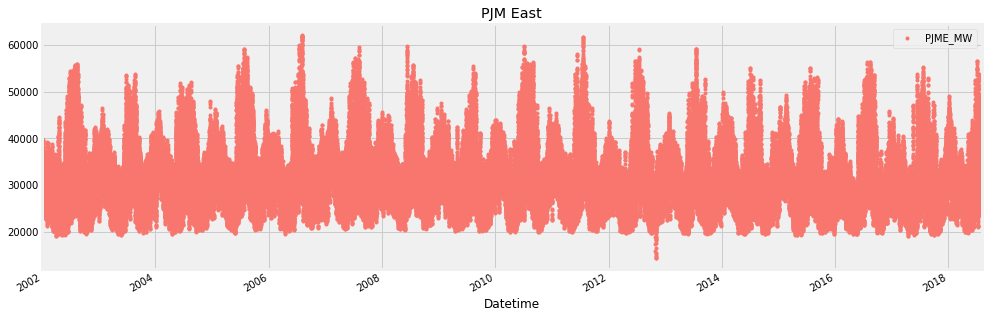

In [3]:
# Plotting timeseries
color_pal = ["#F8766D", "#D39200", "#93AA00", "#00BA38", "#00C19F", "#00B9E3", "#619CFF", "#DB72FB"]
temp_plot = pjme.plot(style='.', figsize=(15,5), color=color_pal[0], title='PJM East')

### Train/Test Split

In [4]:
split_date = '01-JAN-2015'
pjme_train = pjme.loc[pjme.index <= split_date].copy()
pjme_test = pjme.loc[pjme.index > split_date].copy()

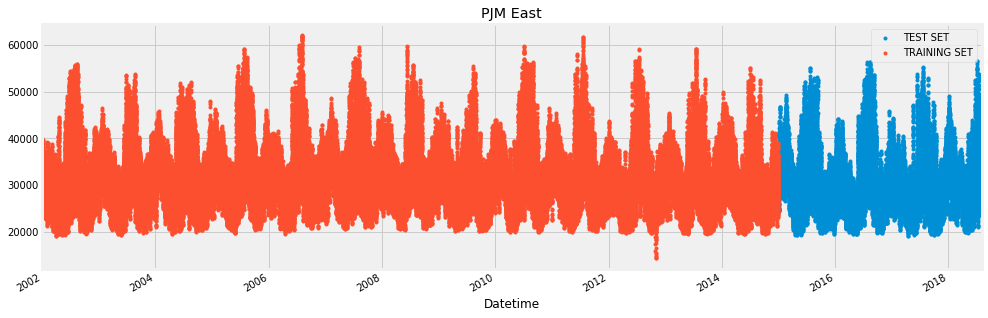

In [5]:
temp_plot = pjme_test \
    .rename(columns={'PJME_MW': 'TEST SET'}) \
    .join(pjme_train.rename(columns={'PJME_MW': 'TRAINING SET'}), how='outer') \
    .plot(figsize=(15,5), title='PJM East', style='.')

### Create Features

In [6]:
def create_lagged_features(df, lag_count):
    """Creates lagged features"""
    # lag_count should be the number of lags to create
    
    for i in range(0, lag_count):
        df['t-{}'.format(i+1)] = df['PJME_MW'].shift(i+1)

    return df

In [7]:
def create_features(df, lag_count, label=None):
    """Creates time series from a datetime index"""
    # Date Features
    df['date'] = df.index
    df['hour'] = df['date'].dt.hour
    df['dayofweek'] = df['date'].dt.dayofweek
    df['quarter'] = df['date'].dt.quarter
    df['month'] = df['date'].dt.month
    df['year'] = df['date'].dt.year
    df['dayofyear'] = df['date'].dt.dayofyear
    df['dayofmonth'] = df['date'].dt.day
    df['weekofyear'] = df['date'].dt.weekofyear
    
    # Lagged Features
    
    df = create_lagged_features(df, lag_count)
    
    column_set = ['hour','dayofweek','quarter','month','year',
                   'dayofyear','dayofmonth','weekofyear']
    
    for i in range(0, lag_count):
        column_set.append('t-{}'.format(i+1))
    
    X = df[column_set]
    
    if label:
        y = df[label]
        # Drop first N (not enough lagged variables)
        X = X[lag_count:]
        y = y[lag_count:]
        return X, y
    
    # Drop first N (not enough lagged variables)
    X = X[lag_count:]
    
    return X

In [8]:
lag_count = 2

X_train, y_train = create_features(pjme_train, lag_count, label='PJME_MW')
X_test, y_test = create_features(pjme_test, lag_count, label='PJME_MW')

In [9]:
print("PJME SHAPE: ", pjme.shape)
print("X_train SHAPE: ", X_train.shape)
print("X_test SHAPE: ", X_test.shape)
print("Dif in rows (expecting lag_count*2): ", pjme.shape[0]-(X_train.shape[0]+X_test.shape[0]))

PJME SHAPE:  (145366, 1)
X_train SHAPE:  (113925, 10)
X_test SHAPE:  (31437, 10)
Dif in rows (expecting lag_count*2):  4


### Create RFR Models and Predict

In [11]:
# Drop first ten rows of test set because X currently drops 10 rows **FIX THIS**
pjme_test = pjme_test[lag_count:]

In [12]:
# Model 1 - Depth 2
start = datetime.datetime.now()
reg = RandomForestRegressor(max_depth=2, random_state=0, n_estimators=100)
reg.fit(X_train, y_train)
end = datetime.datetime.now()
print("Total runtime for reg (depth=2, estimators=100): ", end-start)

Total runtime for reg (depth=2, estimators=100):  0:00:05.246965


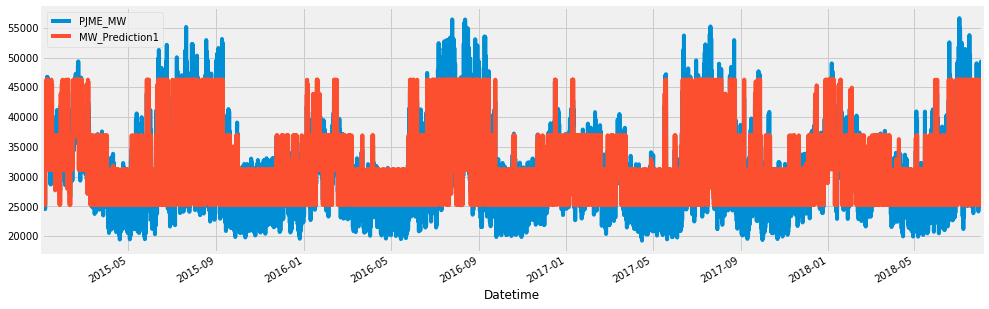

In [14]:
# Plot Reg 1
pjme_test['MW_Prediction1'] = reg.predict(X_test)
temp_plot = pjme_test[['PJME_MW','MW_Prediction1']].plot(figsize=(15, 5))

In [15]:
# Model 2 - Depth 10
start = datetime.datetime.now()
reg2 = RandomForestRegressor(max_depth=10, random_state=0, n_estimators=100)
reg2.fit(X_train, y_train)
end = datetime.datetime.now()
print("Total runtime for reg2 (depth=10, estimators=100): ", end-start)

Total runtime for reg2 (depth=10, estimators=100):  0:00:23.895290


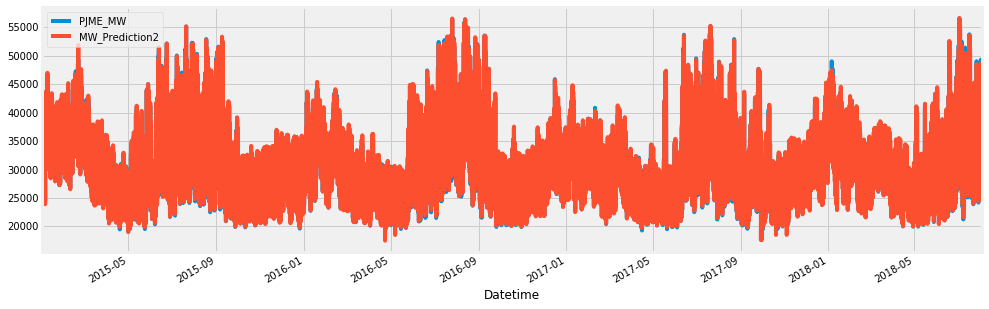

In [16]:
# Plot Reg 2
pjme_test['MW_Prediction2'] = reg2.predict(X_test)
temp_plot = pjme_test[['PJME_MW','MW_Prediction2']].plot(figsize=(15, 5))

In [18]:
# Model 3 - Depth 10
start = datetime.datetime.now()
reg3 = RandomForestRegressor(max_depth=2, random_state=0, n_estimators=1000)
reg3.fit(X_train, y_train)
end = datetime.datetime.now()
print("Total runtime for reg2 (depth=2, estimators=1000): ", end-start)

Total runtime for reg2 (depth=2, estimators=1000):  0:00:50.248602


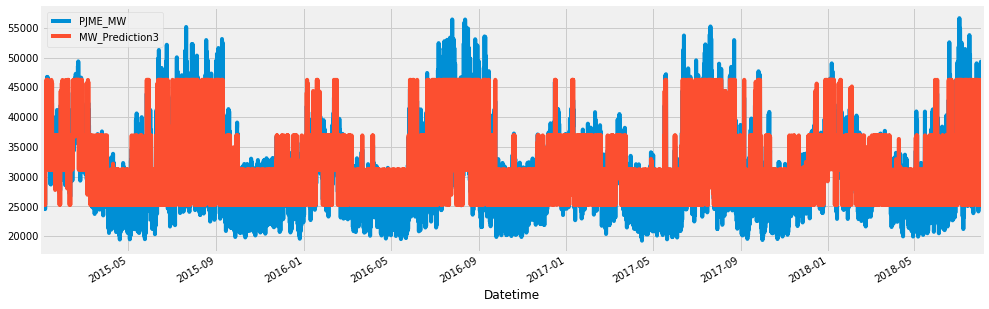

In [19]:
# Plot Reg 3
pjme_test['MW_Prediction3'] = reg3.predict(X_test)
temp_plot = pjme_test[['PJME_MW','MW_Prediction3']].plot(figsize=(15, 5))

In [20]:
# Model 4 - Depth = 10, Estimators = 1000
start = datetime.datetime.now()
reg4 = RandomForestRegressor(max_depth=10, random_state=0, n_estimators=1000)
reg4.fit(X_train, y_train)
end = datetime.datetime.now()
print("Total runtime for reg3 (depth=10, estimators=1000): ", end-start)

Total runtime for reg3 (depth=10, estimators=1000):  0:04:06.352461


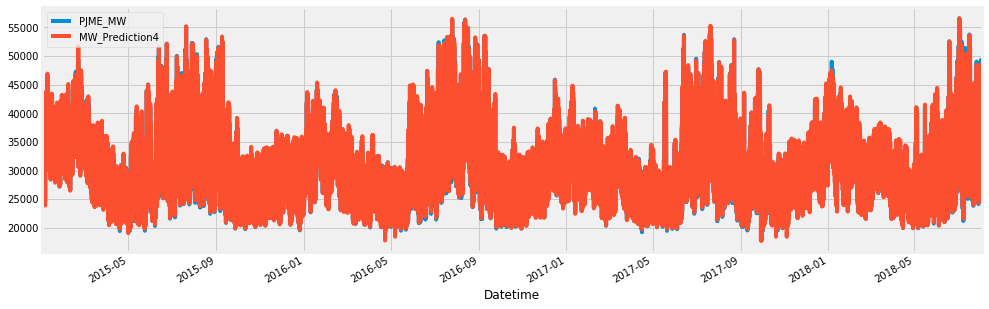

In [21]:
# Plot Reg 4
pjme_test['MW_Prediction4'] = reg4.predict(X_test)
temp_plot = pjme_test[['PJME_MW','MW_Prediction4']].plot(figsize=(15, 5))

### Evaluate Model Performance

In [22]:
import math

def mean_absolute_percentage_error(y_true, y_pred): 
    """Calculates MAPE given y_true and y_pred"""
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

for i in ['MW_Prediction1', 'MW_Prediction2', 'MW_Prediction3', 'MW_Prediction4']:
    print(i)
    print("MSE: ", mean_squared_error(y_true=pjme_test['PJME_MW'], y_pred=pjme_test[i]))
    print("RMSE: ", math.sqrt(mean_squared_error(y_true=pjme_test['PJME_MW'], y_pred=pjme_test[i])))
    print("MAE: ", mean_absolute_error(y_true=pjme_test['PJME_MW'], y_pred=pjme_test[i]))
    print("Mean Absolute Percentage Error: {}%".format(round(mean_absolute_percentage_error(pjme_test['PJME_MW'], pjme_test[i]), 4)))
    print("\n")
    
    

MW_Prediction1
MSE:  6092124.29341019
RMSE:  2468.222901889169
MAE:  1973.3596039330628
Mean Absolute Percentage Error: 6.564%


MW_Prediction2
MSE:  626010.2225433654
RMSE:  791.2080779057842
MAE:  472.6882208898736
Mean Absolute Percentage Error: 1.5449%


MW_Prediction3
MSE:  6108683.8955451725
RMSE:  2471.5751850884835
MAE:  1977.7453001553329
Mean Absolute Percentage Error: 6.5776%


MW_Prediction4
MSE:  626360.6948561557
RMSE:  791.4295261462992
MAE:  472.7682989817727
Mean Absolute Percentage Error: 1.5456%




### Plotting Residuals

In [30]:
# Note: we use MW_Prediction4 for this as it has the largest depth and estimators
pjme_test['error2'] = pjme_test['MW_Prediction2'] - pjme_test['PJME_MW']
pjme_test['error4'] = pjme_test['MW_Prediction4'] - pjme_test['PJME_MW']

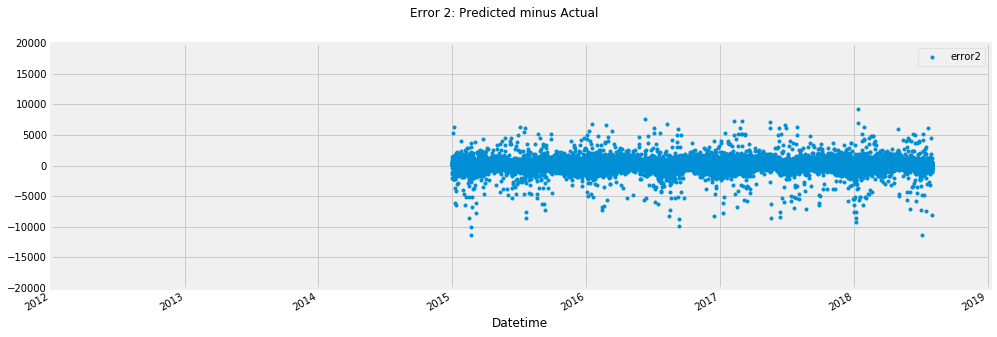

In [31]:
# Plot the forecast against the actual observations
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
temp_plot = pjme_test[['error2']].plot(ax=ax,
                                              style=['.'])
ax.set_xbound(lower='01-01-2012', upper='01-08-2019')
ax.set_ylim(-20000, 20000)
plot = plt.suptitle('Error 2: Predicted minus Actual')

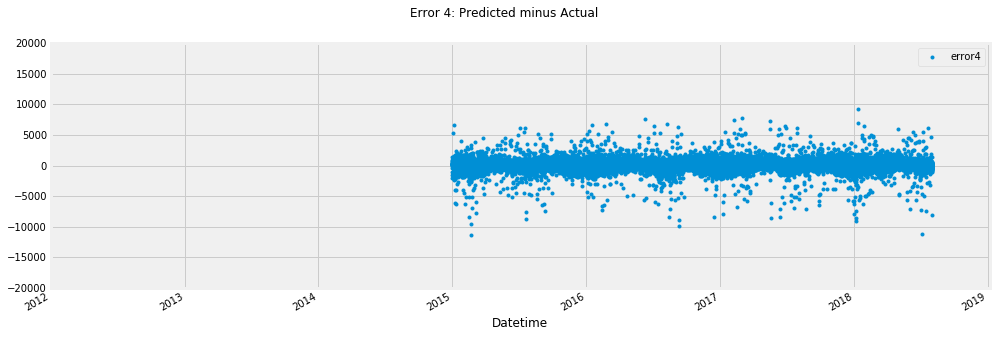

In [32]:
# Plot the forecast against the actual observations
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
temp_plot = pjme_test[['error4']].plot(ax=ax,
                                              style=['.'])
ax.set_xbound(lower='01-01-2012', upper='01-08-2019')
ax.set_ylim(-20000, 20000)
plot = plt.suptitle('Error 4: Predicted minus Actual')

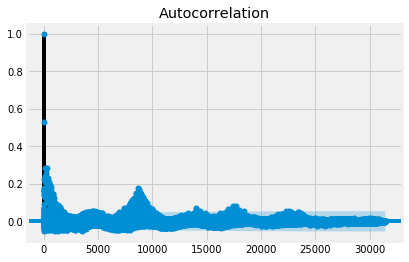

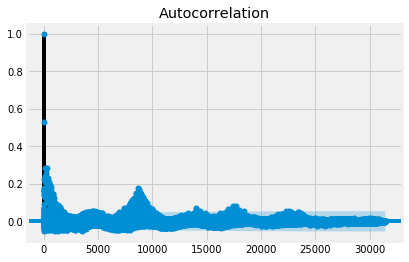

In [33]:
# Plotting Autocorrelation
# Autocorrelation = 1 is perfect correlation
from statsmodels.graphics.tsaplots import plot_acf
series = pjme_test['error2']
plot_acf(series)

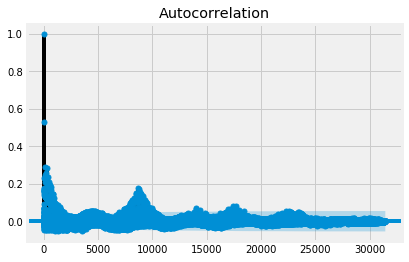

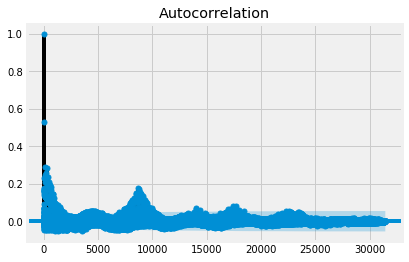

In [34]:
# Plotting Autocorrelation
# Autocorrelation = 1 is perfect correlation
from statsmodels.graphics.tsaplots import plot_acf
series = pjme_test['error4']
plot_acf(series)

### Durbin Watson Test

In [35]:
from statsmodels.stats.stattools import durbin_watson

durbin_watson(pjme_test['error2'])

1.5354672610204987

In [36]:
from statsmodels.stats.stattools import durbin_watson

durbin_watson(pjme_test['error4'])

1.5298010161906095

### Conclusion

The algorithm seems to have predictive power. 

Summary statistics for nested cross-validation are in line with those of the overall model, suggesting generalizability.

#### RMSE: 791.42

#### Mean Absolute Percentage Error: 1.54%

Additionally, the **DW Statistic** for the overall model is fairly near two at 1.53.